# Homework 5 - Group B 4
#### Elie Kostembaum, Joseph Padilla, Daniel Stein, Moshé L. Assaraf

## Imports and data

In [15]:
import pandas as pd
import numpy as np
import datetime
import holidays
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy import interpolate


from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [16]:
zero_coupon_bonds = pd.read_excel('treasury_zero_coupon_2022-12-30.xlsx')
zero_coupon_bonds.set_index('date',inplace=True)
zero_coupon_bonds

,1,2,3,4,5
date,,,,,
1952-06-30,0.981778,0.962531,0.942467,0.926341,0.904183
1952-07-31,0.980948,0.960315,0.939312,0.923089,0.898516
1952-08-29,0.980578,0.959750,0.937819,0.921458,0.895717
1952-09-30,0.980312,0.959098,0.937551,0.920961,0.891676
1952-10-31,0.981108,0.959745,0.937583,0.919290,0.897248
...,...,...,...,...,...
2022-08-31,0.965955,0.933432,0.900600,0.871263,0.846584
2022-09-30,0.959839,0.918517,0.880655,0.846696,0.816731
2022-10-31,0.954288,0.914926,0.876564,0.841926,0.811304


In [17]:
dec_zero_coupon_bonds = zero_coupon_bonds.loc[['2017-12-29', '2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31', '2022-12-30']]
dec_zero_coupon_bonds

,1,2,3,4,5
date,,,,,
2017-12-29,0.982422,0.963139,0.942395,0.918869,0.895638
2018-12-31,0.974310,0.951959,0.929327,0.905801,0.882568
2019-12-31,0.984394,0.968938,0.952964,0.935710,0.918910
2020-12-31,0.998959,0.997520,0.995299,0.989455,0.981537
2021-12-31,0.996173,0.985500,0.971251,0.954872,0.938668
2022-12-30,0.954636,0.916229,0.883347,0.851046,0.820298


## Functions

In [18]:
# (1.1)
def forward_discount_factor(df):
    F_discount_factors = pd.DataFrame(columns=df.columns)
    col = df.columns
    for i in range(len(df.columns)-1):
        F_discount_factors[col[i+1]] = df[col[i+1]].divide(df[col[i]])

    F_curve = pd.DataFrame(F_discount_factors).transpose()
    return F_curve

In [19]:
# (1.2)
def forward_rates(F_discount_factor_curve_df, time_delta):
    f_rates = pd.DataFrame(columns = F_discount_factor_curve_df.columns)
    f_rates = -np.log(F_discount_factor_curve_df.astype('float64'))/time_delta
    return f_rates

In [24]:
# (1.3)
def calc_spot_rate(df):
    spot_rate = -np.log(df)
    spot_rate[2] = spot_rate[2]/2
    spot_rate[3] = spot_rate[3]/3
    spot_rate[4] = spot_rate[4]/4
    spot_rate[5] = spot_rate[5]/5
    return spot_rate.transpose()

## 1 Forward rates
### 1.1 - Forward discount factor

In [25]:
forward_discount_factor_curves = forward_discount_factor(dec_zero_coupon_bonds)
forward_discount_factor_curves

date,2017-12-29,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-30
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.980372,0.97706,0.984299,0.99856,0.989286,0.959768
3,0.978461,0.976226,0.983514,0.997773,0.985541,0.964111
4,0.975036,0.974684,0.981894,0.994129,0.983136,0.963434
5,0.974718,0.974351,0.982046,0.991997,0.983031,0.96387


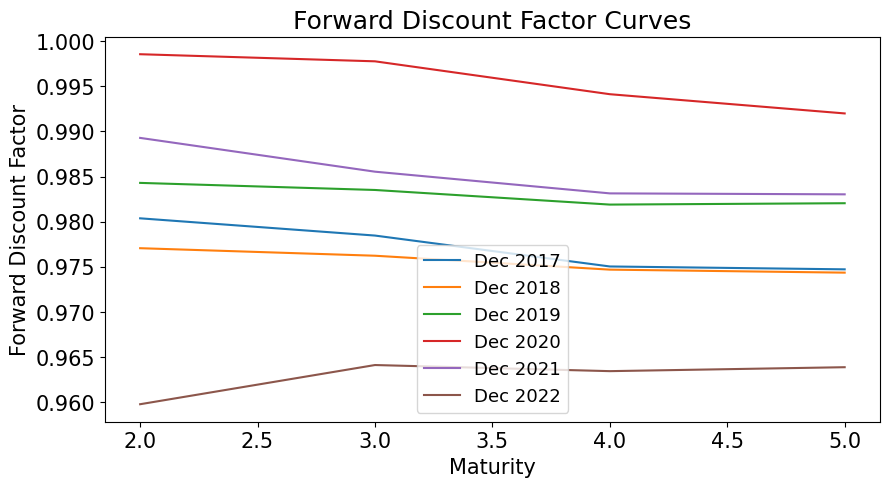

In [26]:
plt.plot(forward_discount_factor_curves)
plt.title('Forward Discount Factor Curves')
plt.xlabel('Maturity')
plt.ylabel('Forward Discount Factor')
plt.legend(['Dec 2017','Dec 2018','Dec 2019','Dec 2020','Dec 2021','Dec 2022'])

### 1.2 - Continuously compounded forward rates

In [27]:
forward_rate_curves = forward_rates(forward_discount_factor_curves,time_delta=1)
forward_rate_curves

date,2017-12-29,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-30
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.019823,0.023207,0.015825,0.001441,0.010772,0.041064
3,0.021774,0.024061,0.016624,0.002229,0.014564,0.036548
4,0.025281,0.025642,0.018272,0.005889,0.017008,0.037252
5,0.025607,0.025984,0.018117,0.008035,0.017115,0.036799


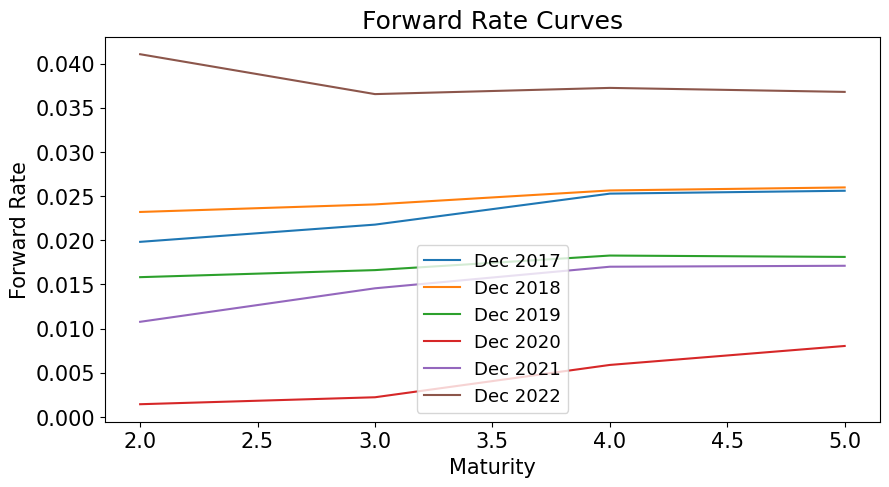

In [28]:
plt.plot(forward_rate_curves)
plt.title('Forward Rate Curves')
plt.xlabel('Maturity')
plt.ylabel('Forward Rate')
plt.legend(['Dec 2017','Dec 2018','Dec 2019','Dec 2020','Dec 2021','Dec 2022'])

### 1.3 - Continuously compounded spot rates
Take the -ln of the zero coupon bonds/T-t (since the are just discount factors)

In [30]:
spot_rate_curves = calc_spot_rate(dec_zero_coupon_bonds)
spot_rate_curves

date,2017-12-29,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-30
1,0.017734,0.026026,0.015729,0.001042,0.003834,0.046425
2,0.018779,0.024617,0.015777,0.001242,0.007303,0.043744
3,0.019777,0.024431,0.016059,0.001571,0.009724,0.041346
4,0.021153,0.024734,0.016612,0.002650,0.011545,0.040322
5,0.022044,0.024984,0.016913,0.003727,0.012659,0.039618


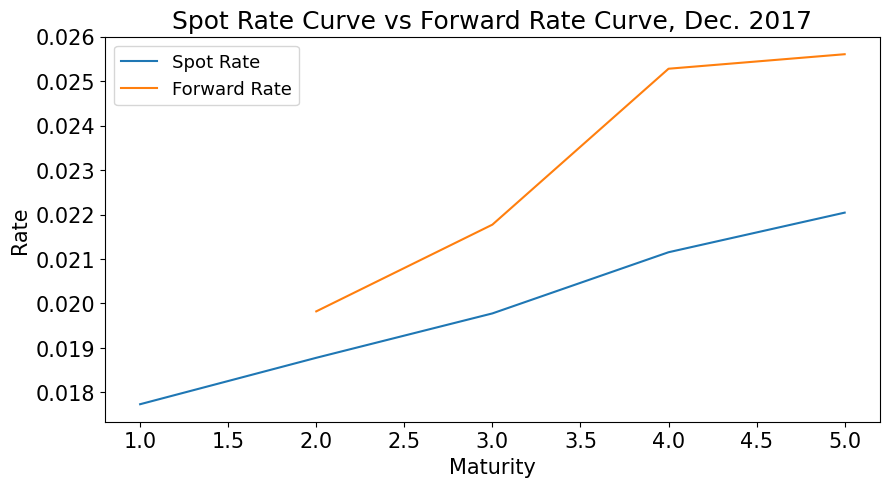

In [31]:
plt.plot(spot_rate_curves['2017-12-29'])
plt.plot(forward_rate_curves['2017-12-29'])
plt.title('Spot Rate Curve vs Forward Rate Curve, Dec. 2017')
plt.xlabel('Maturity')
plt.ylabel('Rate')
plt.legend(['Spot Rate','Forward Rate'])

### 1.4 - Forward rate curve vs spot rates curves

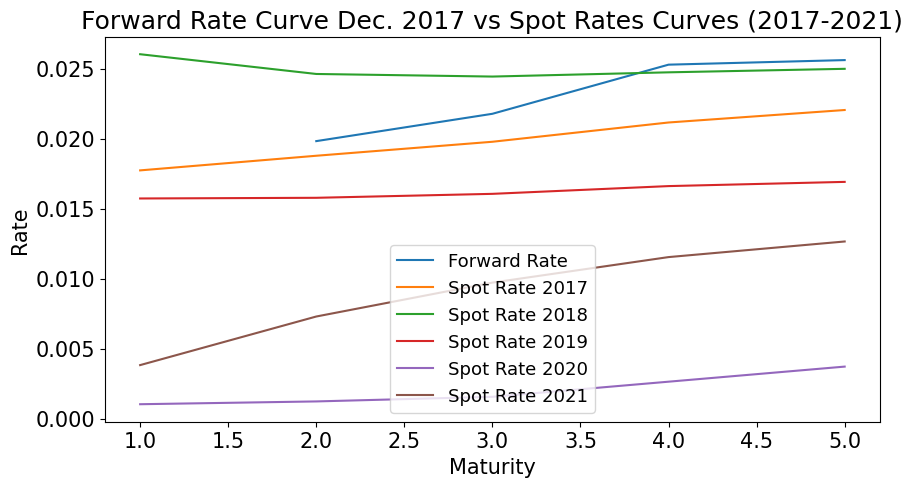

In [33]:
plt.plot(forward_rate_curves['2017-12-29'])
plt.plot(spot_rate_curves[['2017-12-29','2018-12-31','2019-12-31','2020-12-31','2021-12-31']])
plt.title('Forward Rate Curve Dec. 2017 vs Spot Rates Curves (2017-2021)')
plt.xlabel('Maturity')
plt.ylabel('Rate')
plt.legend(['Forward Rate', 'Spot Rate 2017', 'Spot Rate 2018', 'Spot Rate 2019', 'Spot Rate 2020', 'Spot Rate 2021'])

## 2 Carry trade

In [37]:
book = pd.DataFrame(index=zero_coupon_bonds[1].loc['2017-12-29':].index)
book['1yr Bond Prices']=zero_coupon_bonds[1].loc['2017-12-29':]
book['5yr Bond Prices']=zero_coupon_bonds[5].loc['2017-12-29':]
book['1yr Price Return']=book['1yr Bond Prices'].pct_change()
book['5yr Price Return']=book['5yr Bond Prices'].pct_change()
book['Short Position'] = 100*(10**6) * (1-0.02) # adjust for haircut
book['Long Position'] = 100*(10**6) * (1-0.02) # adjust for haircut
book['PnL'] = book['Short Position'] * (1 + book['1yr Price Return']) - book['Long Position'] * (1 + book['5yr Price Return'])
book

,1yr Bond Prices,5yr Bond Prices,1yr Price Return,5yr Price Return,Short Position,Long Position,PnL
date,,,,,,,
2017-12-29,0.982422,0.895638,NaN,NaN,98000000.0,98000000.0,NaN
2018-01-31,0.981420,0.881848,-0.001019,-0.015397,98000000.0,98000000.0,1.408964e+06
2018-02-28,0.979748,0.876329,-0.001705,-0.006258,98000000.0,98000000.0,4.462781e+05
2018-03-29,0.979372,0.879974,-0.000384,0.004159,98000000.0,98000000.0,-4.452099e+05
2018-04-30,0.977809,0.869816,-0.001596,-0.011543,98000000.0,98000000.0,9.748159e+05
...,...,...,...,...,...,...,...
2022-08-31,0.965955,0.846584,-0.005109,-0.032933,98000000.0,98000000.0,2.726706e+06
2022-09-30,0.959839,0.816731,-0.006331,-0.035263,98000000.0,98000000.0,2.835240e+06
2022-10-31,0.954288,0.811304,-0.005784,-0.006645,98000000.0,98000000.0,8.444478e+04


In [43]:
annual_pnl = pd.DataFrame(index=['2019-01-31', '2019-12-31', '2020-12-31', '2021-12-31', '2022-12-30'], columns=['Annual PnL'])
for i, end_of_year in enumerate(annual_pnl.index):
    annual_pnl.loc[end_of_year, 'Annual PnL'] = book.loc[end_of_year, 'PnL'] - book.loc[annual_pnl.index[i-1], 'PnL']
annual_pnl

,Annual PnL
2019-01-31,-1524900.497387
2019-12-31,579159.97328
2020-12-31,-286169.083209
2021-12-31,387742.995539
2022-12-30,844166.611778


In [45]:
final_pnl = book.iloc[-1]['PnL']
initial_capital = 4*(10**6)
total_return = final_pnl / initial_capital
print("Total Return:", total_return.round(4))

Total Return: 0.3104


### 2.2

If the one-year spot rates equaled the forward rates observed in 2017, the Expectations Hypothesis would be proven right. Meaning the following three statements which, in essence are equivalent, would hold up:
1. Long-term yields are the market's expectation of the average future short-term yields.
2. Forward rates are the optimal forcast of future (one-period) yields.
3. Expected returns on holding bonds are equal across maturities.

### 2.3
